# CNN/GNN/LSTM/Transformer Model Test

## Import dependencies and data

In [170]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [171]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [172]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)

In [173]:
# define X vars
x_vars = [
    ('pressure', 'DC_GP101'),
    ('pressure', 'SMHI'),
    ('flow', 'TA01_GP101_default'),
    ('flow', 'FF01_GP101_default'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('humidity', 'DC_GT401_GM401'),
    ('humidity', 'SMHI'),
    ('setpoints', 'DC_GP101_default'),
    ('setpoints', 'TA01_GT10X_GM10X_default')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

In [174]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

# check for NaNs
nadat = data.droplevel(level=0, axis=1)[[
    'TA01_GP101_default', 
    'FF01_GP101_default',
    'DC_GP101_default',
    'TA01_GT10X_GM10X_default'
]]

## display NaNs across days
#print(nadat.isna().groupby(['month', 'day']).sum())
##print(nadat.isna().groupby('day').sum())

## remove NANs
#data = data.dropna(
#    how='any', 
#    subset=x_vars
#)

# delete Nan-data
del nadat

Number of NAs

category      sensor_ID               
pressure      DC_GP101                    0
              SMHI                        0
flow          TA01_GP101_default          0
              FF01_GP101_default          0
temperatures  DC_GT401_GM401              0
              TA01_GT10X_GM10X            0
              DC_GT301_damped             0
              DC_GT301_outdoor            0
humidity      TA01_GT10X_GM10X            0
              DC_GT401_GM401              0
              SMHI                        0
setpoints     DC_GP101_default            0
              TA01_GT10X_GM10X_default    0
dtype: int64





## Process / transform variables 

In [175]:
# outdoors pressure in hPa
# TA02 not needed

# remove erroneous setpoints data
data = data[
    (data.setpoints.TA01_GT10X_GM10X_default != 0.0) &
    (data.setpoints.DC_GP101_default != 0.0)
]

# Use temperature Diff. w.r.t. setpoint
data[('temperatures', 'TA01_GT10X_GM10X')] = \
    data[('temperatures', 'TA01_GT10X_GM10X')] - data[('setpoints', 'TA01_GT10X_GM10X_default')]

# Use rolling avg. f. indoor humidity
data[('humidity', 'TA01_GT10X_GM10X')] = data.humidity.TA01_GT10X_GM10X.rolling(
    window=10,
    center=True
).mean().values

# Use rolling avg. DC-GH humidity
data[('humidity', 'DC_GT401_GM401')] = data.humidity.DC_GT401_GM401.rolling(
    window=10,
    center=True,
).mean().values

# remove NaNs from rolling avgs.
data = data[data.humidity.TA01_GT10X_GM10X.notnull()]

In [176]:
# create variable f. time to account for time-specific effects (e.g. transpiration)

# filter out all data before february
#data['date'] = data.index.get_level_values(3)
#data = data[data.date.apply(lambda d: d.date().isoformat() > '2023-01-31')]
#del data['date']

data[('time', 'minutes')] = data.index.get_level_values(3)
data[('time', 'minutes')] = data.time.minutes.apply(
    lambda d: abs(d.hour * 60 + d.minute - 60 * 12) )

### Plot pairwise correlation matrix

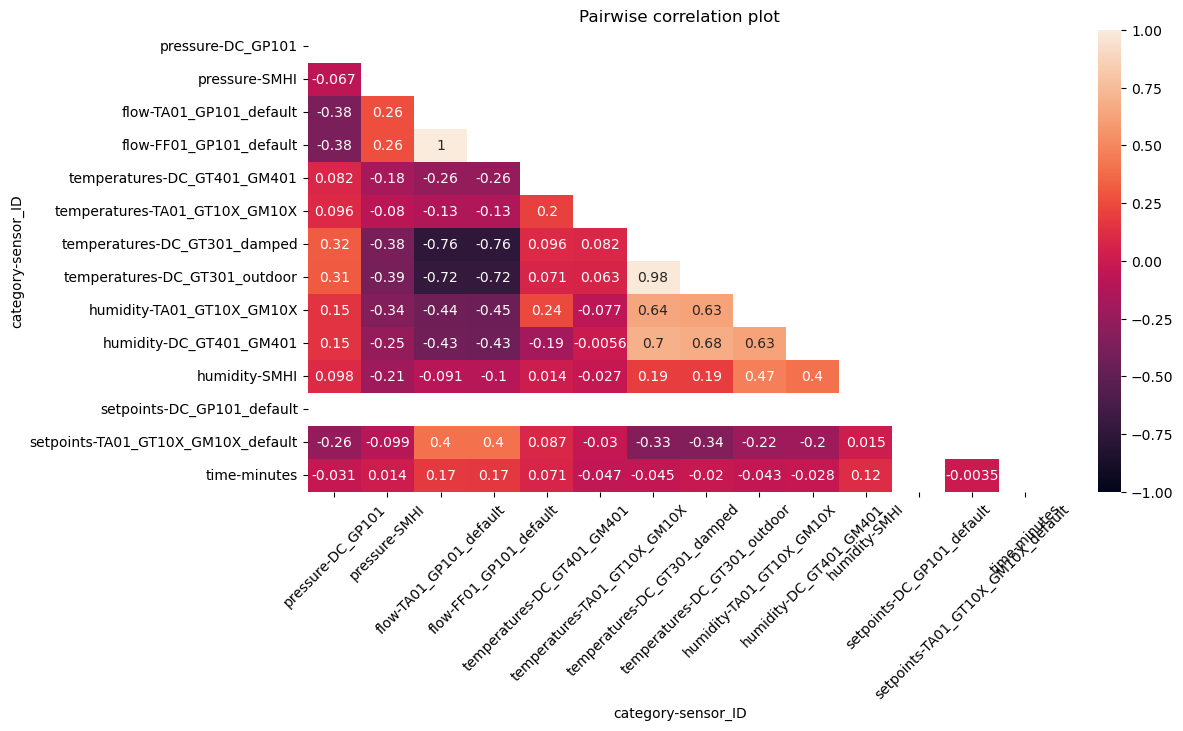

In [177]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 6))
sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True)

plt.xticks(rotation=45)
plt.title('Pairwise correlation plot')
plt.show()

# delete correlation data
del corr

Due to near-perfect correlations, we

    - remove outdoors temp and retain damped temp, 
    - remove flow through FF01 and keep TA01


## Preparing data

In [178]:
### SET N_STEPS
n_steps = 20
t_steps = 4

### MASK f. TRAIN/TEST SPLIT
mask = data.index.get_level_values(0) == 2

### GET MODEL VARS
model_vars = [
    ('pressure', 'DC_GP101'),
    ('pressure', 'SMHI'),
    ('flow', 'TA01_GP101_default'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    #('temperatures', 'DC_GT301_outdoor'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('humidity', 'DC_GT401_GM401'),
    ('humidity', 'SMHI'),
    #('setpoints', 'DC_GP101_default'),
    #('setpoints', 'TA01_GT10X_GM10X_default'),
    #('time', 'minutes')
]

In [179]:
# get train & test data
data_train = data[~mask][model_vars].copy()
data_test  = data[mask][model_vars].copy()

# delete original dataset & filtering mask
del data, mask

# get mean & std f. whitening
mean = np.mean(
    data_train.values, 
    axis=0
)

std  = np.std(
    data_train.values, 
    axis=0
)

### Erroneous seqeunces

Since we have sequential data and missing/removed days, we will have some outlier series for which there is an "erroneous" break. Since e.g. December $16$ is removed from data, there will be sequences for which data starts December $15$ and continues/end in December $17$, and so on. We want to deal with these cases by removing the first number of sequences in a day corresponding to the number of **n_steps**, for when that day is preceded by a *deleted day*.

In [180]:
def date_flagger(data, n_steps):
    # get flagged dates
    data['day'] = data.index.get_level_values(1).values
    data['date_flag'] = data.day - data.day.shift(periods=n_steps) > 1

    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['day'], data['date_flag']
    
    return flagged_idx

def data_split(data, n_steps, t_steps, mean, std):
    """
    Split and whiten data. Using training mean and s.d. also for test data.
    """
    # get flagged dates, accounting for clipped 
    flags = date_flagger(
        data, 
        n_steps
    )
    
    # get numeric data
    dvals = (data.values - mean) / std
    n = len(data)
    
    # delete dataset
    del data
    
    # get all n_step-sequences from data series
    sequences = np.stack([
        dvals[i:i+n_steps, :] for i in range(n - n_steps)
    ]) 
    
    # get mask f. flags
    mask = [idx not in flags for idx in range(len(sequences))]
    sequences = sequences[mask]
    
    # get targets, delete mask
    targets = dvals[n_steps:][mask]
    del mask
    
    # clip t_steps from sequences and targets
    sequences = sequences[:-t_steps]
    targets = targets[t_steps:]
    
    # return sequences w. channel
    #return sequences[..., np.newaxis]
    return sequences, targets

In [181]:
# get sequences f. training and test data
X_train, Y_train = data_split(data_train, n_steps=n_steps, t_steps=t_steps, mean=mean, std=std)
X_test, Y_test = data_split(data_test, n_steps=n_steps, t_steps=t_steps, mean=mean, std=std)

# filter Y-data
####Y_train = Y_train[mask]
Y_train = Y_train[:, 4]
Y_test = Y_test[:, 4]

# delete data sets
del data_train, data_test

## Define model

In [203]:
layerList = [
    layers.Input(shape=(
        X_train.shape[1],
        X_train.shape[2]
    )),
    layers.Conv1D(
        filters=128,
        kernel_size=7, 
        padding="same", 
        strides=2, 
        activation="relu"
    ),
    layers.Dropout(rate=0.2),
    layers.Conv1D(
        filters=64,
        kernel_size=7, 
        padding="same", 
        strides=2, 
        activation="relu"
    ),
    layers.Dropout(rate=0.2),
    layers.Flatten(),
    #layers.LSTM(
    #    units=128,
    #    activation='tanh',
    #    recurrent_activation='sigmoid'
    #),
    layers.Dense(128, activation='relu'),
    #layers.Dense(256, activation='relu'),
    layers.Dense(1, activation=None)
]

In [204]:
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 10, 128)           8192      
                                                                 
 dropout_18 (Dropout)        (None, 10, 128)           0         
                                                                 
 conv1d_17 (Conv1D)          (None, 5, 64)             57408     
                                                                 
 dropout_19 (Dropout)        (None, 5, 64)             0         
                                                                 
 flatten_7 (Flatten)         (None, 320)               0         
                                                                 
 dense_32 (Dense)            (None, 128)               41088     
                                                                 
 dense_33 (Dense)            (None, 1)                 129   

In [205]:
trainHist = model.fit(
    X_train,
    Y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/10
1403/1403 [==============================] - 15s 10ms/step - loss: 0.2304 - val_loss: 0.0509
Epoch 2/10
1403/1403 [==============================] - 15s 10ms/step - loss: 0.1980 - val_loss: 0.0711
Epoch 3/10
1403/1403 [==============================] - 14s 10ms/step - loss: 0.1898 - val_loss: 0.1264
Epoch 4/10
1403/1403 [==============================] - 15s 11ms/step - loss: 0.1761 - val_loss: 0.0621
Epoch 5/10
1403/1403 [==============================] - 15s 11ms/step - loss: 0.1745 - val_loss: 0.1488
Epoch 6/10
1403/1403 [==============================] - 15s 11ms/step - loss: 0.1638 - val_loss: 0.1166


In [206]:
preds = model.predict(X_test)

1705/1705 [==============================] - 4s 2ms/step


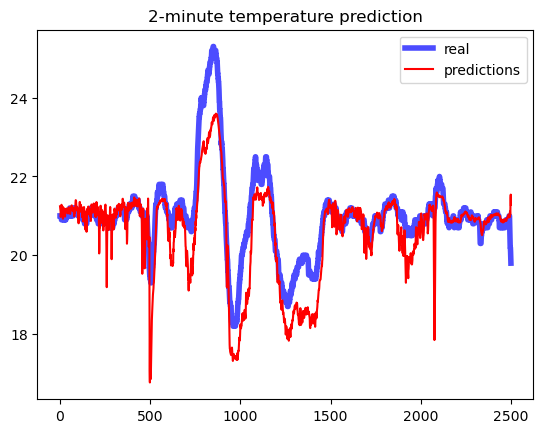

In [211]:
plt.plot(Y_test[-2500:] * std[4] + mean[4] + 21, c='b', linewidth=4.0, alpha=0.7, label='real')
plt.plot(preds[-2500:] * std[4] + mean[4] + 21, c='r', linewidth=1.5, alpha=1.0, label='predictions')

plt.title('2-minute temperature prediction')
plt.legend()
plt.show()